Introduction: The goal of this task is to predict the intent of the customer given their query text input. The dataset is ATIS (Airline Travel Information System) and consists of (query, intent) pairs. For this problem, you will implement the Bag of Word technique and a fully connected neural network to predict the intent of query text.

In [4]:
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit as activation_function  # 1/(1+exp(-x)), sigmoid
from scipy.stats import truncnorm

if True:  # recreate MNIST arrays. Do it only once, after that modify to False
    train_data = np.loadtxt("dataset/mnist_train.csv", delimiter=",")
    test_data = np.loadtxt("dataset/mnist_test.csv", delimiter=",")
    train_imgs = np.asfarray(train_data[:, 1:]) / 255.0
    test_imgs = np.asfarray(test_data[:, 1:]) / 255.0
    train_labels = np.asfarray(train_data[:, :1])
    test_labels = np.asfarray(test_data[:, :1])
    lr = np.arange(10)
    train_labels_one_hot = (lr==train_labels).astype(np.float)
    test_labels_one_hot = (lr==test_labels).astype(np.float)
    for i, d in enumerate([train_imgs, test_imgs, train_labels, test_labels, train_labels_one_hot, test_labels_one_hot]):
        np.save('%i.array' % i, d)

(train_imgs, test_imgs, train_labels, test_labels, train_labels_one_hot, test_labels_one_hot) = [np.load('%i.array.npy' % i) for i in range(6)]

print ('Data loaded.')

if False:  # show images
    for i in range(10):
        img = train_imgs[i].reshape((28,28))
        plt.imshow(img, cmap="Greys")
        plt.show()

class NeuralNetwork:
    def __init__(self, network_structure, learning_rate, bias=None):  
        self.structure = network_structure
        self.no_of_layers = len(self.structure)
        self.learning_rate = learning_rate 
        self.bias = bias
        self.create_weight_matrices()

    def create_weight_matrices(self):
        bias_node = 1 if self.bias else 0
        self.weights_matrices = []
        for k in range(self.no_of_layers-1):
            nodes_in = self.structure[k]
            nodes_out = self.structure[k+1]
            n = (nodes_in + bias_node) * nodes_out
            X = truncnorm(-1, 1,  loc=0, scale=1)
            #X = truncnorm(-1 / np.sqrt(nodes_in), 1 / np.sqrt(nodes_in),  loc=0, scale=1)  # accuracy is worse
            wm = X.rvs(n).reshape((nodes_out, nodes_in + bias_node))
            self.weights_matrices.append(wm)

    def train(self, input_vector, target_vector): 
        input_vector = np.array(input_vector, ndmin=2).T
        res_vectors = [input_vector]
        for k in range(self.no_of_layers-1):
            in_vector = res_vectors[-1]
            if self.bias:
                in_vector = np.concatenate((in_vector, [[self.bias]]))
                res_vectors[-1] = in_vector
            x = np.dot(self.weights_matrices[k], in_vector)
            out_vector = activation_function(x)
            res_vectors.append(out_vector)    

        target_vector = np.array(target_vector, ndmin=2).T
        output_errors = target_vector - out_vector  
        for k in range(self.no_of_layers-1, 0, -1):
            out_vector = res_vectors[k]
            in_vector = res_vectors[k-1]
            if self.bias and not k==(self.no_of_layers-1):
                out_vector = out_vector[:-1,:].copy()
            tmp = output_errors * out_vector * (1.0 - out_vector)  # sigma'(x) = sigma(x) (1 - sigma(x))
            tmp = np.dot(tmp, in_vector.T)
            self.weights_matrices[k-1] += self.learning_rate * tmp
            output_errors = np.dot(self.weights_matrices[k-1].T, output_errors)
            if self.bias:
                output_errors = output_errors[:-1,:]

    def run(self, input_vector):
        if self.bias:
            input_vector = np.concatenate((input_vector, [self.bias]))
        in_vector = np.array(input_vector, ndmin=2).T
        for k in range(self.no_of_layers-1):
            x = np.dot(self.weights_matrices[k], in_vector)
            out_vector = activation_function(x)
            in_vector = out_vector
            if self.bias:
                in_vector = np.concatenate((in_vector, [[self.bias]]))
        return out_vector

    def evaluate(self, data, labels):
        corrects, wrongs = 0, 0
        for i in range(len(data)):
            res = self.run(data[i])
            res_max = res.argmax()
            if res_max == labels[i]:
                corrects += 1
            else:
                wrongs += 1
        return corrects, wrongs

ANN = NeuralNetwork(network_structure=[784, 200, 80, 10], learning_rate=0.01, bias=None)

for epoch in range(3):
    for i in range(len(train_imgs)):
        # if i % 1000 == 0:
            # print ('epoch:', epoch, 'img number:', i, '/', len(train_imgs))
        ANN.train(train_imgs[i], train_labels_one_hot[i])

corrects, wrongs = ANN.evaluate(test_imgs, test_labels)
print("accruracy: test", corrects / (corrects + wrongs))

C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_26696\429407754.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels_one_hot = (lr==train_labels).astype(np.float)
C:\Users\HP OMEN\AppData\Local\Temp\ipykernel_26696\429407754.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_labels_one_hot = (lr==test_labels).astype(np.f

Data loaded.
accruracy: test 0.9612


In [21]:
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
from matplotlib import pyplot as plt
from random import randint

# Preparing the dataset
# Setup train and test splits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Making a copy before flattening for the next code-segment which displays images
x_train_drawing = x_train

image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) 
x_test = x_test.reshape(x_test.shape[0], image_size)


In [22]:
# Convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)



In [71]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Train & Evaluate The Network

This code trains and evaluates the model we defined above. It also uses `matplotlib` and the history object provided by Keras, which tracks how the model behaves through it's training. The history object is worth exploring further, here we are using it to plot training and validation accuracy over time. 

In [23]:
def create_dense(layer_sizes):
    model = Sequential()
    model.add(Dense(layer_sizes[0], activation='sigmoid', input_shape=(image_size,)))

    for s in layer_sizes[1:]:
        model.add(Dense(units = s, activation = 'sigmoid'))

    model.add(Dense(units=num_classes, activation='softmax'))

    return model

def evaluate(model, batch_size=128, epochs=5):
    model.summary()
    model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=.1, verbose=False)
    loss, accuracy  = model.evaluate(x_test, y_test, verbose=False)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['training', 'validation'], loc='best')
    plt.show()

    print()
    print(f'Test loss: {loss:.2}')
    print(f'Test accuracy: {accuracy:.2}')


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 2048)              1607680   
                                                                 
 dense_11 (Dense)            (None, 10)                20490     
                                                                 
Total params: 1,628,170
Trainable params: 1,628,170
Non-trainable params: 0
_________________________________________________________________


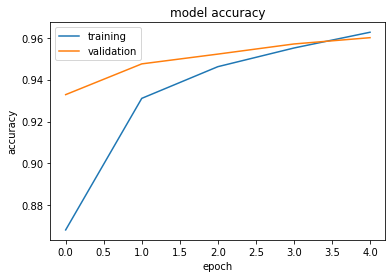


Test loss: 0.18
Test accuracy: 0.95


In [24]:
model = create_dense([2048])
evaluate(model)

## Convolutional Neural Network

In [25]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import math

In [33]:
def CNNet(input_shape = (32, 32, 1), classes = 10):
    """
    Implementation of a modified LeNet-5.
    Only those layers with learnable parameters are counted in the layer numbering.
    
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    model = Sequential([
        
    # Layer 1
    Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (32,32,1), kernel_regularizer=l2(0.0005), name = 'convolution_1'),
    
    # Layer 2
    Conv2D(filters = 32, kernel_size = 5, strides = 1, name = 'convolution_2', use_bias=False),
    
    # Layer 3    
    BatchNormalization(name = 'batchnorm_1'),
        
    # -------------------------------- #  
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_1'),
    Dropout(0.25, name = 'dropout_1'),
    # -------------------------------- #  
        
    # Layer 3
    Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005), name = 'convolution_3'),
        
    # Layer 4
    Conv2D(filters = 64, kernel_size = 3, strides = 1, name = 'convolution_4', use_bias=False),
        
    # Layer 5
    BatchNormalization(name = 'batchnorm_2'),
        
    # -------------------------------- #  
    Activation("relu"),
    MaxPooling2D(pool_size = 2, strides = 2, name = 'max_pool_2'),
    Dropout(0.25, name = 'dropout_2'),
    Flatten(name = 'flatten'),
    # -------------------------------- #  
        
    # Layer 6
    Dense(units = 256, name = 'fully_connected_1', use_bias=False),
        
    # Layer 7
    BatchNormalization(name = 'batchnorm_3'),
    
    # -------------------------------- #  
    Activation("relu"),
    # -------------------------------- #  
        
    # Layer 8
    Dense(units = 128, name = 'fully_connected_2', use_bias=False),
        
    # Layer 9
    BatchNormalization(name = 'batchnorm_4'),
        
    # -------------------------------- #  
    Activation("relu"),
    # -------------------------------- #  
        
    # Layer 10
    Dense(units = 84, name = 'fully_connected_3', use_bias=False),
        
    # Layer 11
    BatchNormalization(name = 'batchnorm_5'),
        
    # -------------------------------- #  
    Activation("relu"),
    Dropout(0.25, name = 'dropout_3'),
    # -------------------------------- #  

    # Output
    Dense(units = 10, activation = 'softmax', name = 'output')
        
    ])
    
    model._name = 'CNNet'

    return model

In [34]:
CNN_Model = CNNet(input_shape = (32, 32, 1), classes = 10)

In [35]:
CNN_Model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
CNN_Model.summary()

Model: "CNNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution_1 (Conv2D)      (None, 28, 28, 32)        832       
                                                                 
 convolution_2 (Conv2D)      (None, 24, 24, 32)        25600     
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 24, 24, 32)       128       
 tion)                                                           
                                                                 
 activation_5 (Activation)   (None, 24, 24, 32)        0         
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 12, 12, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0         
                                                             

In [67]:
#summarize filters in each convolutional layer

for layer in CNN_Model.layers:
    #check for convolutional layer
    if 'conv' not in layer.name:
        continue

    # #get filter weights
    filter = layer.get_weights()[0]
    print(layer.name, filter.shape)
    f_min, f_max = filter.min(), filter.max()
    filter_nrm = (filter - f_min) / (f_max - f_min)
    

convolution_1 (5, 5, 1, 32)
convolution_2 (5, 5, 32, 32)
convolution_3 (3, 3, 32, 64)
convolution_4 (3, 3, 64, 64)


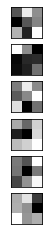

In [70]:
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filter[:, :, :, i]
	# plot each channel separately
	for j in range(1):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 1, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

Size of Dataset:  42000
Size of Cross Validation Set:  2100


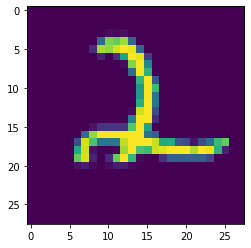

In [43]:
train = pd.read_csv("digit-recognizer/train_mnist.csv")
test = pd.read_csv("digit-recognizer/test_mnist.csv")

train.head()
Y = train[['label']]
X = train.drop(train.columns[[0]], axis=1)

X = X.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

print("Size of Dataset: " , len(X))

cross_validation_size = int(len(X)*0.05)

print("Size of Cross Validation Set: " , cross_validation_size)

random_seed = 2
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = cross_validation_size, random_state=random_seed)

X_test = test

plt.imshow(X_train[2][:,:,0])

In [44]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# Padding the images by 2 pixels since in the paper input images were 32x32
X_train = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_val = np.pad(X_val, ((0,0),(2,2),(2,2),(0,0)), 'constant')
X_test = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')

# Standardization
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)
X_train = (X_train - mean_px)/(std_px)

mean_px = X_val.mean().astype(np.float32)
std_px = X_val.std().astype(np.float32)
X_val = (X_val - mean_px)/(std_px)

mean_px = X_test.mean().astype(np.float32)
std_px = X_test.std().astype(np.float32)
X_test = (X_test - mean_px)/(std_px)

# One-hot encoding the labels
Y_train = to_categorical(Y_train, num_classes = 10)
Y_val = to_categorical(Y_val, num_classes = 10)

In [45]:
# By using the image generator, we are not generating new data. We are only replacing the existing images. 

datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip = False)  # randomly flip images

datagen.fit(X_train)

In [46]:
variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2)

In [47]:
history = CNN_Model.fit(X_train, Y_train, epochs = 30, batch_size = 64, callbacks = [variable_learning_rate], validation_data = (X_val,Y_val))

Epoch 1/30
624/624 [==============================] - 93s 147ms/step - loss: 0.2567 - accuracy: 0.9334 - val_loss: 0.1383 - val_accuracy: 0.9643 - lr: 0.0010
Epoch 2/30
624/624 [==============================] - 90s 144ms/step - loss: 0.0955 - accuracy: 0.9776 - val_loss: 0.0740 - val_accuracy: 0.9843 - lr: 0.0010
Epoch 3/30
624/624 [==============================] - 95s 153ms/step - loss: 0.0768 - accuracy: 0.9826 - val_loss: 0.0519 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 4/30
624/624 [==============================] - 102s 163ms/step - loss: 0.0675 - accuracy: 0.9842 - val_loss: 0.0457 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 5/30
624/624 [==============================] - 92s 147ms/step - loss: 0.0565 - accuracy: 0.9872 - val_loss: 0.0463 - val_accuracy: 0.9890 - lr: 0.0010
Epoch 6/30
624/624 [==============================] - 91s 146ms/step - loss: 0.0542 - accuracy: 0.9869 - val_loss: 0.0451 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 7/30
624/624 [==============================]

<Figure size 432x288 with 0 Axes>

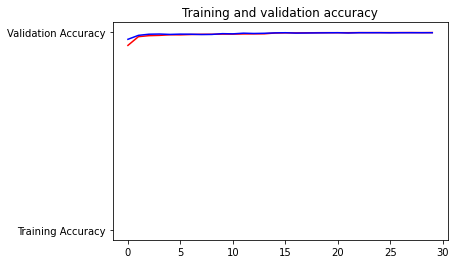

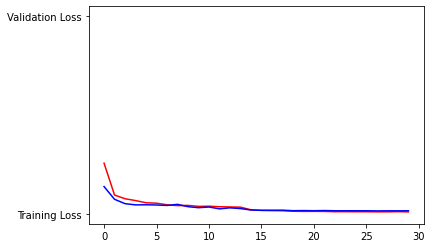

<Figure size 432x288 with 0 Axes>

In [48]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()

## 3. Comparing the performance of the two models

When using CNN, spatial features are extracted from image input, making CNN ideal when thousands of features need to be extracted. Instead of having to measure each individual feature, CNN gathers these features on its own. By doing this, there are less trainable parameters in a CNN, as seen above, we have 389,434 trainable parameters compared to ANN which has 1,628,170. 

ANN having 1,628,170 is because 2-dimensional images need to be converted to 1-dimensional vectors. This increases the number of trainable parameters exponentially. Increasing trainable parameters is simply an expensive venture on storage and processing capability.

